# Synopsis

Create an LDA topic model from scratch using collapsed Gibbs Sampling.

# Configuration

In [1]:
base_path = '/Users/rca2t/COURSES/DSI/DS5559/UVA_DSI_REPO'
local_lib = base_path + '/lib'
src_dir = base_path + '/play/lda/corpora'
corpus_db = "20news.db"

In [2]:
n_docs = 100
n_topics = 15
n_iters = 100
alpha = 1
beta = 1

# Libraries

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import re
import random
import sys; sys.path.append(local_lib)
import textman.textman as tx
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Pragmas

In [4]:
%matplotlib inline

# Process

## Get corpus from database

Corpus we imported into a SQLite database earlier. We  grab a sample of N docs, as specified in the configuration.

In [5]:
sql = """
SELECT * FROM doc 
WHERE doc_label LIKE '%christian%' 
    OR doc_label LIKE '%baseball%' 
    OR doc_label LIKE '%politics%' 
    OR doc_label LIKE '%hardware%'
    OR doc_label LIKE '%hockey%'
ORDER BY RANDOM() LIMIT ?
"""
with sqlite3.connect(src_dir + "/" + corpus_db) as db:
    docs = pd.read_sql(sql, db, index_col='doc_id', params=(n_docs,))

### Show labels

Get a sense of what the corpus is about.

In [6]:
docs.doc_label.value_counts()

soc.religion.christian      16
comp.sys.ibm.pc.hardware    16
talk.politics.mideast       14
rec.sport.hockey            14
rec.sport.baseball          11
talk.politics.misc          10
talk.politics.guns          10
comp.sys.mac.hardware        9
Name: doc_label, dtype: int64

## Convert corpus to tokens and vocab

We use a function from TextMan, a bespoke library that incorporates the text processing routines used in earlier notebooks.

In [7]:
tokens, vocab = tx.create_tokens_and_vocab(docs, src_col='doc_content')
tokens['token_num'] = tokens.groupby(['doc_id']).cumcount()
tokens = tokens.reset_index()[['doc_id','token_num','term_id']]
tokens = tokens[tokens.term_id.isin(vocab[vocab.go].index)]
tokens = tokens.set_index(['doc_id','token_num'])

### We add the term strings for convenience

In [8]:
tokens['term_str'] = tokens.term_id.map(vocab.term)

In [9]:
tokens.head()

term_id   term_str
doc_id token_num                    
52263  0             1682     couple
       1             3595     months
       2              697        ago
       3             4883  something
       4             5659      white

###  Remove redundant words

We actually *don't* do this because it ruins performance!

In [10]:
# tokens = tokens.reset_index().drop_duplicates(['doc_id','term_id']).set_index(['doc_id','token_num'])

In [11]:
# tokens.head()

## Remove insignificant words

We use SKlearn's TFIDF vectorizor to quicky get a TFIDF vector space, which we use only to filter the words in our corpus.

In [12]:
vectorizer = TfidfVectorizer(use_idf=1, stop_words='english', token_pattern=r'[A-Za-z][A-Za-z][A-Za-z]+')
X = vectorizer.fit_transform(docs.doc_content.values.tolist())
v = pd.DataFrame(vectorizer.get_feature_names(), columns=['term_str'])
v['idf'] = vectorizer.idf_

In [13]:
v.sort_values('idf', ascending=False).head(10)

,term_str,idf
0,aazaadee,4.921973
2912,netcomsv,4.921973
2891,neatest,4.921973
2893,necessity,4.921973
2897,neely,4.921973
2899,negatively,4.921973
2900,neglect,4.921973
2901,negotiated,4.921973
2902,negotiations,4.921973
2903,nehzat,4.921973


### We take a look at the distribution of significance

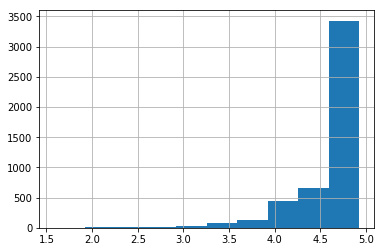

In [14]:
v.idf.hist()

### We take only the most significant words

In [15]:
v = v[v.idf > 4.5]
my_v = v.term_str.tolist()

In [16]:
tokens = tokens[tokens.term_str.isin(my_v)]

In [17]:
vocab = vocab[vocab.term.isin(my_v)]

In [18]:
tokens.head(10)

term_id   term_str
doc_id token_num                    
52263  5             3309      lines
       11            3309      lines
       12            1329  cartridge
       16            3309      lines
       27            3021        isc
76160  8             3965  paragraph
       9             5150     tartar
       14            5150     tartar
       16            3965  paragraph
       21            4604    russian

## Create topics table

We will use this to collect information about topics, and in our sampling routine.

In [19]:
topics = pd.DataFrame(index=range(n_topics))
topics.index.name = 'topic_id'

## Define functions

### Randomly assign topics to tokens

In [20]:
def init_topics(tokens):
    tokens['topic_id'] = np.random.randint(0, n_topics, len(tokens))
    return tokens

In [21]:
# tokens = init_topics(tokens)

In [22]:
# tokens.head()

### Generate Count Matrices

In [23]:
def get_DT(tokens):
    return tokens.groupby(['doc_id','topic_id']).topic_id.count()\
        .unstack().fillna(0).astype('int')

In [24]:
def get_WT(tokens):
    return tokens.groupby(['topic_id','term_id']).term_id.count()\
        .unstack().fillna(0).astype('int').T

In [25]:
def get_DTP(dt):
    return (dt.T / dt.T.sum()).T

In [26]:
def get_WTP(wt):
    wtp = wt / wt.sum()
    wtp['term_str'] = vocab.term
    wtp = wtp.set_index('term_str')
    return wtp

In [27]:
def get_topic_seeds(wt):
    seeds = pd.DataFrame([(t, wt[t].sort_values().idxmax()) for t in range(n_topics)], columns=['t','w'])
    seeds = seeds.set_index('t')
    seeds['term_str'] = seeds.w.map(vocab.term)
    seeds = seeds.sort_values('term_str')
    return seeds

In [28]:
def get_doc_seeds(dt):
    seeds = pd.DataFrame([(d, DT.loc[d].idxmax()) for d in DT.index], columns=['d','t'])
    seeds = seeds.set_index('d')
    return seeds

In [29]:
def add_topic_info(topics, dt, wt, n_words = 7):
    dtp = get_DTP(dt)
    wtp = get_WTP(wt)
    topics['top_words'] = ''
    topics['top_words'] = topics.apply(lambda x: ' '.join(wtp[x.name].sort_values(ascending=False).head(n_words).index.values), 1)    
    topics['df_max'] = topics.apply(lambda x: dtp[x.name].max(), 1)
    topics['df_mean'] = topics.apply(lambda x: dtp[x.name].mean(), 1)
    topics['df_sum'] = topics.apply(lambda x: dtp[x.name].sum(), 1)
    topics['n_words'] = topics.apply(lambda x: wt[x.name].sum(), 1)
    return topics

### Print topics

In [30]:
def plot_topics(wtp, n=5):
    fig, axes = plt.subplots(nrows=n_topics, ncols=1, sharex=True)
    for t in range(n_topics):
        wtp[t].sort_values(ascending=True).tail(10).plot(kind='barh', ax=axes[t], figsize=(5,80))
        axes[t].set_title('Topic {}'.format(t))

## Use Collapsed Gibbs Sampling

See [this blog](http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/).

Or, better, see [Griffiths 2002](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.138.3760).

### Define row function

In [31]:
def get_new_topic(row):
    
    d = row.name[0] # doc_id
    k = row.name[1] # token_num (not used)
    z = row.topic_id
    w = row.term_id
    
    DT.at[d,z] -= 1
    WT.at[w,z] -= 1
    
    p_z = DT.loc[d] * (WT.loc[w] / WT.sum())
    z_weights = p_z / p_z.sum()

    z1 = topics.sample(weights=z_weights).index.values[0]

    DT.at[d,z1] += 1
    WT.at[w,z1] += 1
    
    return z1

### Generate model

In [32]:
tokens = init_topics(tokens)
DT = get_DT(tokens) + alpha
WT = get_WT(tokens) + beta
topic_seeds = get_topic_seeds(WT)
doc_seeds = get_doc_seeds(WT)

In [33]:
topic_seeds

,w,term_str
t,,
9,613,abstinence
13,970,azerbaijan
5,1143,bodies
10,1152,bonds
2,1329,cartridge
3,1836,defensive
4,2376,firearms
11,2613,greeks
6,2968,insurance


In [34]:
doc_seeds.t.value_counts()

3     12
1     10
0     10
4      9
2      9
8      7
7      6
5      6
14     5
13     3
12     3
11     3
9      3
6      3
10     1
Name: t, dtype: int64

In [35]:
for i in range(n_iters):
    print(i, end=' ')
    tokens['topic_id'] = tokens.apply(get_new_topic, 1)
print('Done')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Done


In [36]:
topics = add_topic_info(topics, DT, WT)

In [37]:
topics.top_words

topic_id
0     libertarians analysis ratio regulation isc ste...
1          handheld roby rkba udel cartridge bleeds vga
2     runs defensive bonds daulton firearms hash rickey
3     abstinence curricula kids pregnancy drug drugs...
4            bede spring easter week dawn feast meaning
5     azerbaijan hojali bodies bathroom greeks azeri...
6       smith venerable week video ozzie cross congress
7        bson cramer sei sportster nous badges fighting
8     insurance private health canadian doctors cost...
9     agents milwaukee ulowell kill seeing stuff driver
10        owners sold mercy sell attendance places fnal
11    traditions mary dab catholic catholics creed t...
12                          det nyi chi cal buf tor van
13    praise converted visser paragraph gregorian ag...
14    israeli media hernlem ncsu british occupation ...
Name: top_words, dtype: object

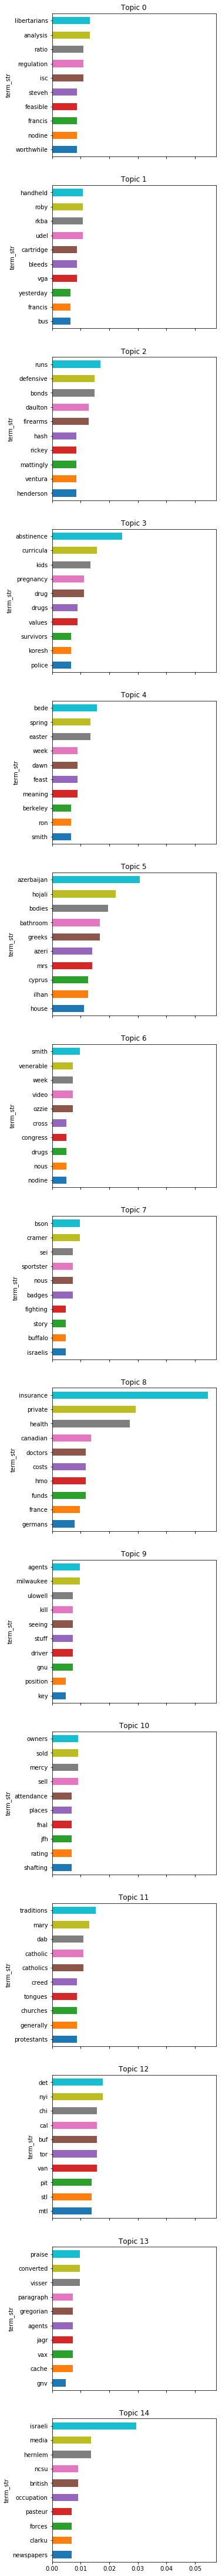

In [38]:
plot_topics(get_WTP(WT), 7)